Starting training...
i 10000
i 20000
i 30000
i 40000
i 50000
i 60000
Epoch 1 done. Training Accuracy: 89.81, Test Loss: 0.1880244781484015, Test Accuracy: 93.89
i 10000
i 20000
i 30000
i 40000
i 50000
i 60000
Epoch 2 done. Training Accuracy: 95.81, Test Loss: 0.14050660120819483, Test Accuracy: 95.29
i 10000
i 20000
i 30000
i 40000
i 50000
i 60000
Epoch 3 done. Training Accuracy: 96.52, Test Loss: 0.12438330327535273, Test Accuracy: 96.05
798.891964 seconds (8.24 G allocations: 1.125 TiB, 9.12% gc time, 0.92% compilation time)


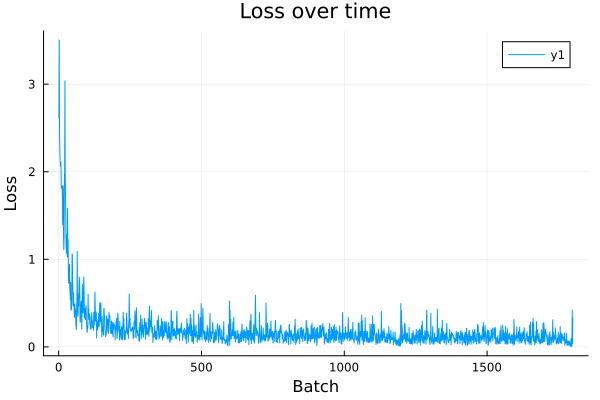

In [1]:
using Statistics

include("ConvolutionModule.jl")
include("PoolingModule.jl")
include("FlattenModule.jl")
include("DenseModule.jl")

include("MNISTDataLoader.jl")
include("LossAndAccuracy.jl")
include("NetworkHandlers.jl")

using .ConvolutionModule, .PoolingModule, .MNISTDataLoader, .FlattenModule, .DenseModule

# Load and preprocess the data
train_features, train_labels = MNISTDataLoader.load_data(:train)
train_x, train_y = MNISTDataLoader.preprocess_data(train_features, train_labels; one_hot=true)

# for i in eachindex(axes(train_x, 4))
#     input = train_x[:, :, :, i]
#     (height, width, channels) = size(input)
#     if height != 28 || width != 28 || channels != 1
#         println("Input $i: height=$height, width=$width, channels=$channels")
#     end
# end

# Load and preprocess test data
test_features, test_labels = MNISTDataLoader.load_data(:test)
test_x, test_y = MNISTDataLoader.preprocess_data(test_features, test_labels; one_hot=true)

# Create batches
batch_size = 100
train_data = MNISTDataLoader.batch_data((train_x, train_y), batch_size; shuffle=true)
# input_image = Float64.(input_image)

sample_input = train_x[:, :, :, 1]

# Initialize layers
conv_layer1 = ConvolutionModule.init_conv_layer(3, 3, 1, 6, 1, 0, 3697631579, 28, 28, 1)
pool_layer1 = PoolingModule.init_pool_layer(2, 2, 2, 26, 26, 6)
conv_layer2 = ConvolutionModule.init_conv_layer(3, 3, 6, 16, 1, 0, 3731614026, 13, 13, 6)
pool_layer2 = PoolingModule.init_pool_layer(2, 2, 2, 11, 11, 16)
flatten_layer = FlattenModule.FlattenLayer()
dense_layer1 = DenseModule.init_dense_layer(400, 84, DenseModule.relu, DenseModule.relu_grad, 4172219205)
dense_layer2 = DenseModule.init_dense_layer(84, 10, DenseModule.identity, DenseModule.identity_grad, 3762133366)

# Workaround because of namespaces...
function backward_pass_master(network, grad_loss)
    for layer in reverse(network)
        if isa(layer, ConvolutionModule.ConvLayer)
            grad_loss = ConvolutionModule.backward_pass(layer, grad_loss)

        elseif isa(layer, PoolingModule.MaxPoolLayer)
            grad_loss = PoolingModule.backward_pass(layer, grad_loss)

        elseif isa(layer, DenseModule.DenseLayer)
            grad_loss = DenseModule.backward_pass(layer, grad_loss)

        elseif isa(layer, FlattenModule.FlattenLayer)
            grad_loss = FlattenModule.backward_pass(layer, grad_loss)
        else
            println("No backward pass defined for layer type $(typeof(layer))")
        end
    end
    return grad_loss
end

function update_weights(network, learning_rate)
    for layer in reverse(network)
        if isa(layer, DenseModule.DenseLayer) || isa(layer, ConvolutionModule.ConvLayer)
            # println("Type of layer ", typeof(layer))

            # println("Previous weights grad ", layer.grad_weights[1:2, :])

            layer.grad_weights ./= batch_size
            layer.grad_biases ./= batch_size
            # println("Normalized weights grad ", layer.grad_weights[1:2, :])

            # println("Previous weights ", layer.weights[1:2, :])

            layer.weights .-= learning_rate * layer.grad_weights
            layer.biases .-= learning_rate * layer.grad_biases



            # println("Updated weights ", layer.weights[1:2, :])

            fill!(layer.grad_weights, 0)
            fill!(layer.grad_biases, 0)
        end
    end
end

# Function to evaluate the model on test data
function evaluate_model(network, test_x, test_y)
    total_loss = 0.0
    total_accuracy = 0.0
    num_samples = size(test_x, 4)

    for i in 1:num_samples
        input = test_x[:, :, :, i]
        target = test_y[:, i]

        # Forward pass
        output = NetworkHandlers.forward_pass_master(network, input)

        # Calculate loss and accuracy
        loss, accuracy, _ = LossAndAccuracy.loss_and_accuracy(output, target)
        total_loss += loss
        total_accuracy += accuracy
    end

    # Calculate average loss and accuracy
    avg_loss = total_loss / num_samples
    avg_accuracy = total_accuracy / num_samples
    return avg_loss, avg_accuracy
end

# Assemble the network
network = (conv_layer1, pool_layer1, conv_layer2, pool_layer2, flatten_layer, dense_layer1, dense_layer2)

using .NetworkHandlers, .LossAndAccuracy
epochs = 3
training_step = 0.5

println("Starting training...")

plot_loss = Float64[]
batch_loss = 0.0
@time begin
    for epoch in 1:epochs
        accumulated_accuracy_epoch = 0.0
        accumulated_accuracy_batch = 0.0
        for i in eachindex(axes(train_x, 4))
            input = train_x[:, :, :, i]
            target = train_y[:, i]

            output = NetworkHandlers.forward_pass_master(network, input)

            loss, accuracy, grad_loss = LossAndAccuracy.loss_and_accuracy(output, target)
            accumulated_accuracy_epoch += accuracy
            accumulated_accuracy_batch += accuracy
            batch_loss += loss
            # if i % 100 == 0
            #     println("Loss: ", loss)
            #     println("Accuracy: ", round(accumulated_accuracy_batch / 100, digits=2))
            #     accumulated_accuracy_batch = 0.0
            # end

            if i % 10000 == 0
                println("i ", i)
            end

            backward_pass_master(network, grad_loss)

            if i % batch_size == 0
                plot_loss = push!(plot_loss, batch_loss / batch_size)
                batch_loss = 0.0
                update_weights(network, training_step)
            end
        end
        # println("Epoch $(epoch) done")
        # println("Accuracy: ", round(accumulated_accuracy_epoch / size(train_x, 4), digits=2))
        # accumulated_accuracy_epoch = 0.0

        test_loss, test_accuracy = evaluate_model(network, test_x, test_y)
        println("Epoch $(epoch) done. Training Accuracy: $(round(accumulated_accuracy_epoch / size(train_x, 4), digits=2)), Test Loss: $test_loss, Test Accuracy: $test_accuracy")

        # Update weights at the end of each epoch
        update_weights(network, training_step)
    end
end

# Plot
using Plots

plot(plot_loss, xlabel="Batch", ylabel="Loss", title="Loss over time")